# Temperature Dataset

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson



import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [3]:
url1 = ('https://raw.githubusercontent.com/prajwalghotkar/Time-Series-SARIMAX-Model/refs/heads/main/Time_Series_Temp_Data.csv')

df = pd.read_csv(url1)

df.head()

,DATE,Temp,relative_humidity,wind_speed,Pressure
0,1/1/2020,-0.44,86.0,18.5,100.15
1,1/2/2020,-0.09,79.0,14.0,100.47
2,1/3/2020,2.95,82.0,12.0,100.64
3,1/4/2020,-0.80,86.0,15.0,100.75
4,1/5/2020,-7.95,74.5,15.0,101.06


In [4]:
# Convert 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

# Sort the DataFrame by index (date)
df.sort_index(inplace=True)

# Show the cleaned DataFrame
df.head()

,Temp,relative_humidity,wind_speed,Pressure
DATE,,,,
2020-01-01,-0.44,86.0,18.5,100.15
2020-01-02,-0.09,79.0,14.0,100.47
2020-01-03,2.95,82.0,12.0,100.64
2020-01-04,-0.80,86.0,15.0,100.75
2020-01-05,-7.95,74.5,15.0,101.06


In [5]:
df.tail()

,Temp,relative_humidity,wind_speed,Pressure
DATE,,,,
2021-06-03,18.55,83.5,12.0,101.14
2021-06-04,20.80,78.0,18.0,100.85
2021-06-05,22.75,71.5,13.5,100.76
2021-06-06,24.60,70.0,16.0,101.10
2021-06-07,26.10,57.0,19.5,101.24


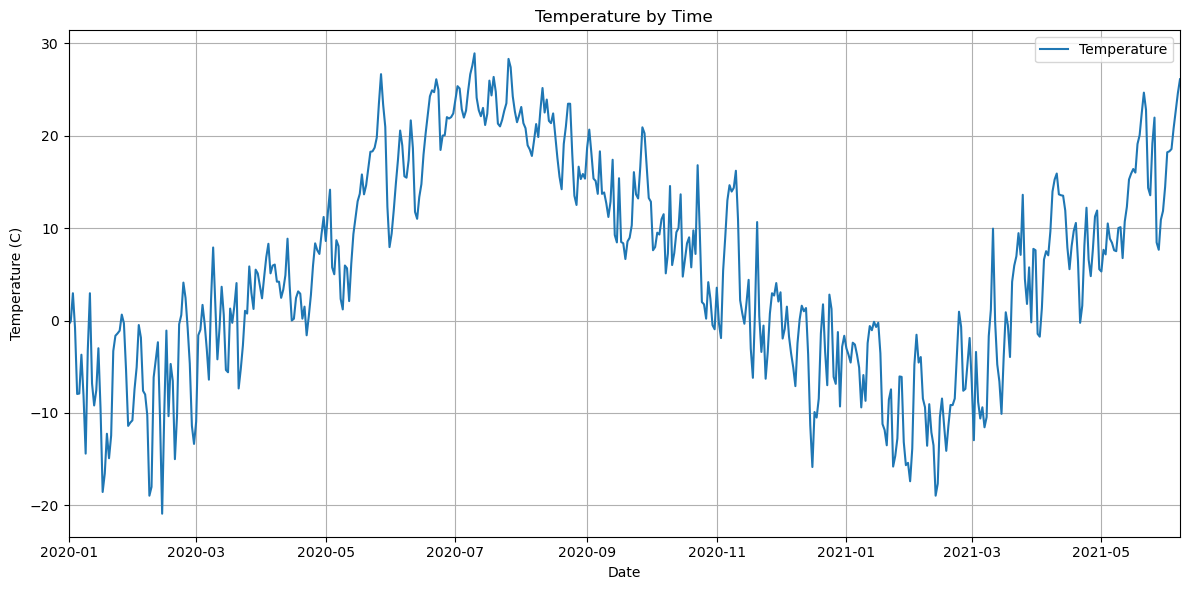

In [6]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df.index, df['Temp'], label='Temperature')     

plt.title('Temperature by Time')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (C)')  
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-06-07'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [7]:
# Convert index to datetime and remove time/microseconds
df.index = pd.to_datetime(df.index).normalize()

# Split the data
cutoff = pd.to_datetime("2021-05-01")

train = df[df.index < cutoff]
test = df[df.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (486, 4)
Test shape: (38, 4)

             Temp  relative_humidity  wind_speed  Pressure
DATE                                                      
2021-04-26   4.80               38.0        20.5    101.73
2021-04-27   7.70               48.0         7.0    101.58
2021-04-28  11.25               61.0         8.0    101.11
2021-04-29  11.90               71.5         7.5    100.38
2021-04-30   5.55               84.5        29.5     99.98

             Temp  relative_humidity  wind_speed  Pressure
DATE                                                      
2021-05-01   5.30               62.5        21.0    101.03
2021-05-02   7.65               69.5        13.5    100.58
2021-05-03   7.15               57.5        16.5    101.19
2021-05-04  10.50               68.0        18.0    100.62
2021-05-05   8.85               83.0        20.0    100.76


In [8]:
temp_series = train['Temp']

In [9]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(temp_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.5021, p-value = 0.5325
d = 1 | ADF Statistic = -10.6614, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [10]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(temp_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


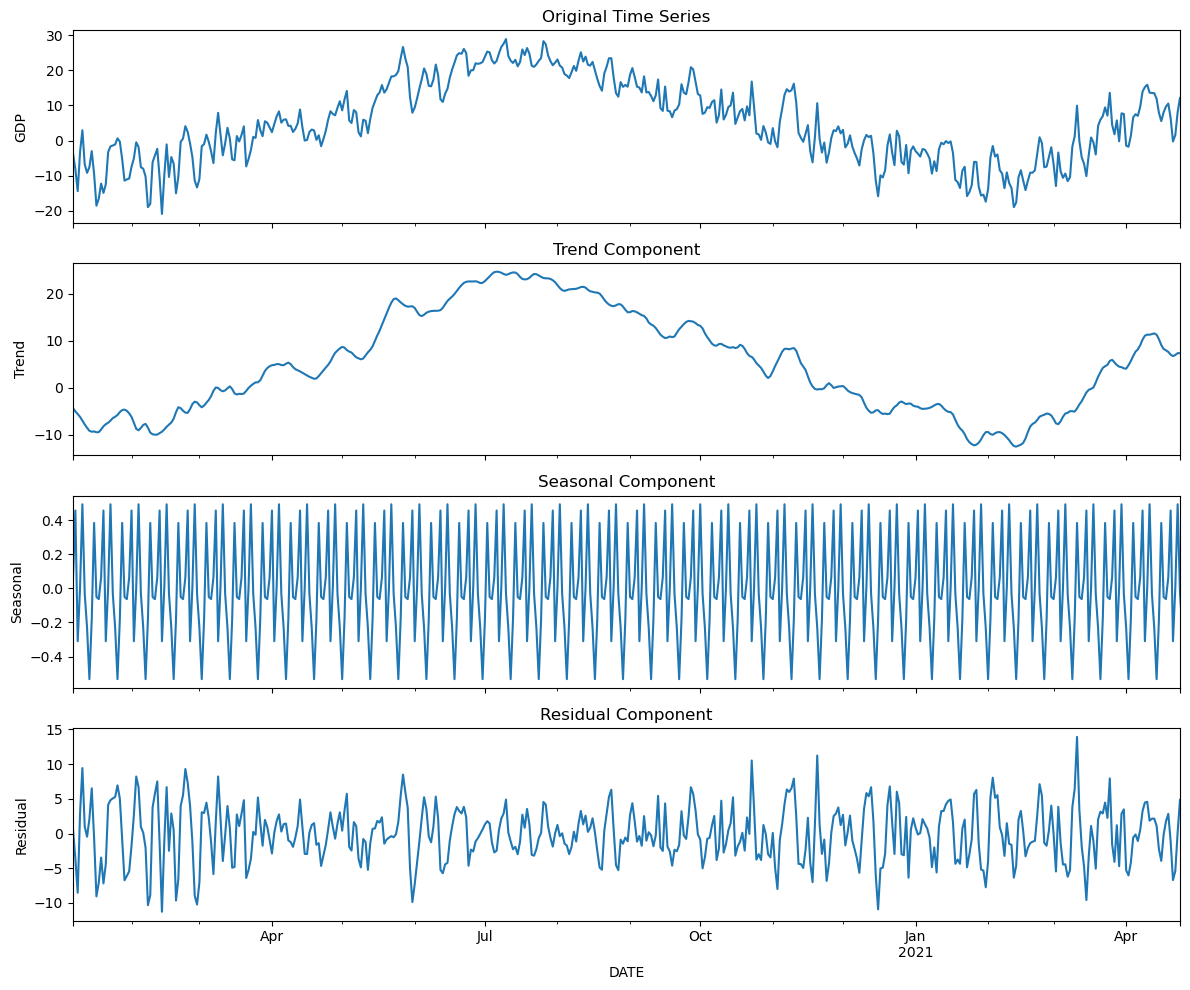

In [11]:
result = seasonal_decompose(temp_series, model='aditive', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('GDP')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [12]:
seasonal

DATE
2020-01-01   -0.232600
2020-01-02   -0.533113
2020-01-03   -0.182493
2020-01-04    0.383885
2020-01-05   -0.050378
                ...   
2021-04-26   -0.533113
2021-04-27   -0.182493
2021-04-28    0.383885
2021-04-29   -0.050378
2021-04-30   -0.063102
Freq: D, Name: seasonal, Length: 486, dtype: float64

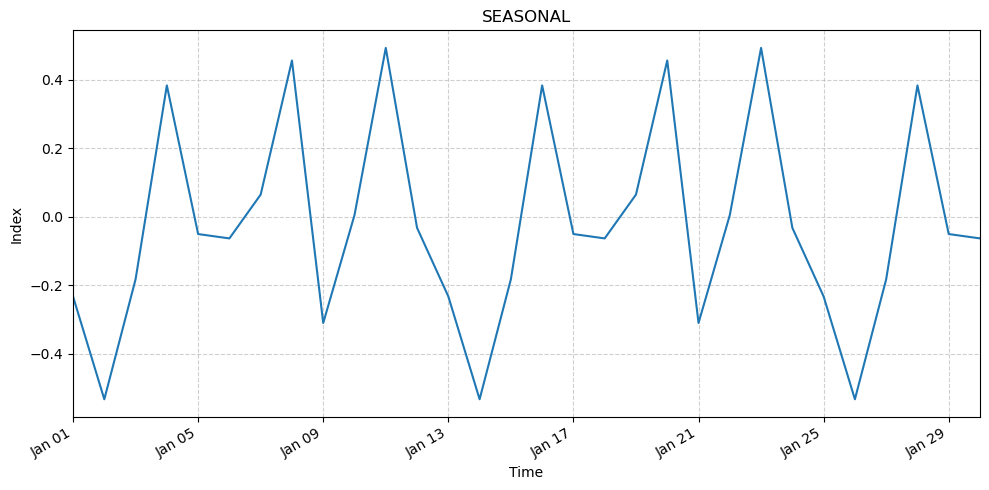

In [13]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(seasonal)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('SEASONAL')
ax.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-01-30'))
ax.grid(linestyle='--', alpha=0.6)  

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate and resize

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [14]:
D = nsdiffs(temp_series, m=12, test='ch') # Canova-Hansen Test (ch) is designed for monthly or quarterly data.
print("Seasonal differencing term (D):", D)

Seasonal differencing term (D): 0


In [15]:
# Perform a full search over the same grid as the manual SARIMAX model
auto_model = pm.auto_arima(
    temp_series,                # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=2,         # P 
    start_Q=0, max_Q=2,         # Q 
    stepwise=True,              # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(1, 1, 2)(0, 0, 0, 12)


In [16]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(3))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 2
d = 1
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(temp_series,                   # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 144
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,1)(2,0,0,12)
Running model #30 using SARIMA(0,1,3)(1,0,0,12)
Running model #45 using SARIMA(1,1,1)(0,0,0,12)
Running model #60 using SARIMA(1,1,2)(2,0,0,12)
Running model #75 using SARIMA(2,1,0)(1,0,0,12)
Running model #90 using SARIMA(2,1,2)(0,0,0,12)
Running model #105 using SARIMA(2,1,3)(2,0,0,12)
Running model #120 using SARIMA(3,1,1)(1,0,0,12)
Running model #135 using SARIMA(3,1,3)(0,0,0,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,65,"(1, 1, 3)","(0, 0, 2)",2483.021303,2483.270747,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,29,"(0, 1, 3)","(0, 0, 2)",2483.793416,2483.980083,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,101,"(2, 1, 3)","(0, 0, 2)",2484.3081,2484.629529,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,68,"(1, 1, 3)","(1, 0, 2)",2484.825468,2485.146896,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,32,"(0, 1, 3)","(1, 0, 2)",2485.465829,2485.715272,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


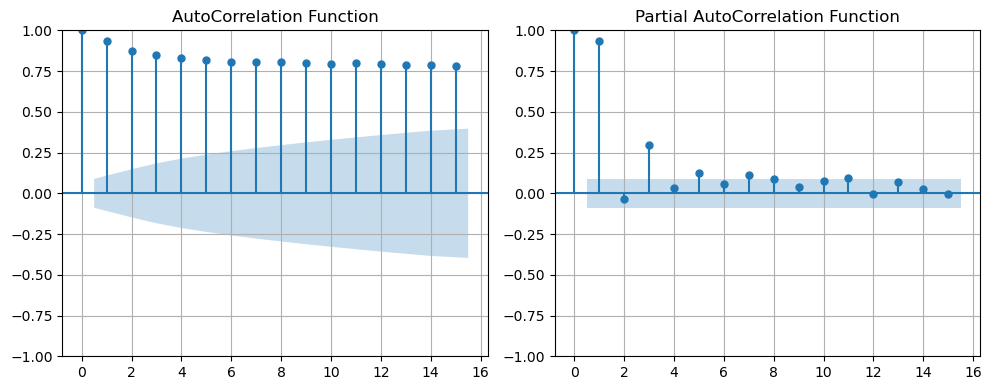

In [17]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(temp_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(temp_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_113 = SARIMAX(temp_series,                         # Time series data
                    order=(1, 1, 3),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 2, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_113 = model_113.fit()

# Display summary of the model
print(model_fit_113.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                    Temp   No. Observations:                  486
Model:             SARIMAX(1, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -1234.511
Date:                                 Wed, 30 Apr 2025   AIC                           2483.021
Time:                                         14:38:07   BIC                           2511.894
Sample:                                     01-01-2020   HQIC                          2494.394
                                          - 04-30-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3745      0.253      1.481      0.139      -0.121       0

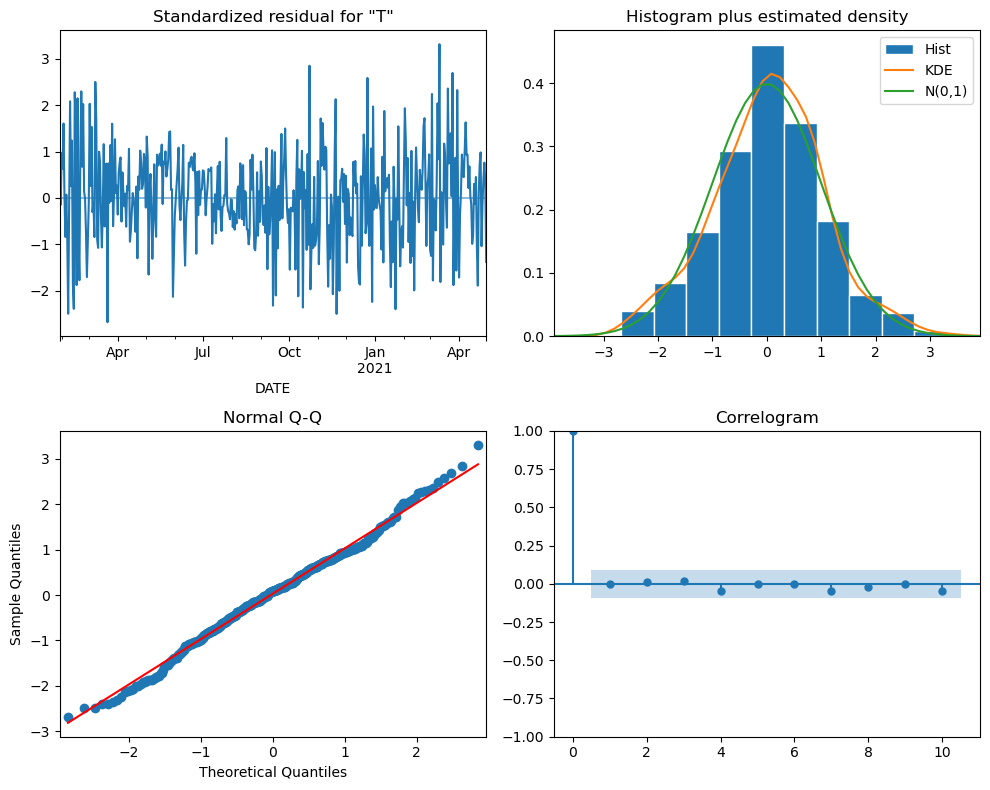

In [19]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_113.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [20]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_113.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.029929,0.862652
2,2.409241,0.299806
3,2.973470,0.395734
4,3.123755,0.537333
5,3.440659,0.632385
6,5.888261,0.435823
7,6.684260,0.462478
8,7.252337,0.509668
9,7.338434,0.601929
10,10.688323,0.382310


In [21]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.0104
Conclusion: No significant autocorrelation.


In [22]:
# Forecast the next steps time points
forecast_113 = model_fit_113.get_forecast(steps=38)

# Extract predicted mean and confidence intervals
forecast_mean_113 = forecast_113.predicted_mean
conf_int_113 = forecast_113.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_113.values               # Forecast mean

test['Error S'] = test['Forecast S'] - test['Temp']

test['Lower 95% CI S'] = conf_int_113.iloc[:, 0].values     # Lower bound
test['Upper 95% CI S'] = conf_int_113.iloc[:, 1].values     # Upper bound

# Show the updated test DataFrame
test.head()

,Temp,relative_humidity,wind_speed,Pressure,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
DATE,,,,,,,,
2021-05-01,5.30,62.5,21.0,101.03,5.309932,0.009932,-1.749394,12.369258
2021-05-02,7.65,69.5,13.5,100.58,7.578377,-0.071623,-1.938847,17.095601
2021-05-03,7.15,57.5,16.5,101.19,8.363521,1.213521,-1.771729,18.498770
2021-05-04,10.50,68.0,18.0,100.62,8.478919,-2.021081,-1.993646,18.951485
2021-05-05,8.85,83.0,20.0,100.76,8.205051,-0.644949,-2.521149,18.931251


# Analysis with Exogenous Variables

In [23]:
train.head()

,Temp,relative_humidity,wind_speed,Pressure
DATE,,,,
2020-01-01,-0.44,86.0,18.5,100.15
2020-01-02,-0.09,79.0,14.0,100.47
2020-01-03,2.95,82.0,12.0,100.64
2020-01-04,-0.80,86.0,15.0,100.75
2020-01-05,-7.95,74.5,15.0,101.06


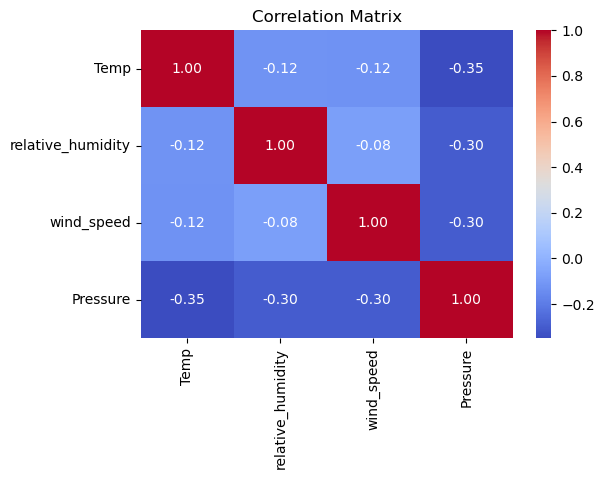

In [24]:
# Compute correlation matrix
correlation_matrix = train.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select candidate variables
X = train[['relative_humidity', 'wind_speed', 'Pressure']]

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 2) for i in range(len(X.columns))]

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix (rounded to 2 decimals)
corr = X.corr().round(2)
print(f'Correlation:\n{corr}')

             feature    VIF
0  relative_humidity  29.94
1         wind_speed   9.12
2           Pressure  39.86

Correlation:
                   relative_humidity  wind_speed  Pressure
relative_humidity               1.00       -0.08      -0.3
wind_speed                     -0.08        1.00      -0.3
Pressure                       -0.30       -0.30       1.0


    VIF < 5 : Not Multicollinearity
    VIF 5-10: Moderate Multicollinearity
    VIF > 10: High Multicollinearity

In [26]:
exog_data = train[['Pressure']]  # Multiple column selection
endog_data = train['Temp']       # Target variable selection

In [27]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                    exog=exog_data, 
                    order=(1, 1, 3), 
                    seasonal_order=(0, 0, 2, 12),
                    enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                    Temp   No. Observations:                  486
Model:             SARIMAX(1, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -1160.879
Date:                                 Wed, 30 Apr 2025   AIC                           2337.758
Time:                                         14:38:09   BIC                           2370.756
Sample:                                     01-01-2020   HQIC                          2350.755
                                          - 04-30-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pressure      -3.2301      0.215    -14.991      0.000      -3.652      -2

In [28]:
# Must match the structure of training exog
exog_test_M = test[['Pressure']] 

# Forecast the next 42 time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=38, exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['Temp']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,Temp,relative_humidity,wind_speed,Pressure,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
DATE,,,,,,,,,,,,
2021-05-01,5.30,62.5,21.0,101.03,5.309932,0.009932,-1.749394,12.369258,2.191462,-3.108538,-3.818371,8.201294
2021-05-02,7.65,69.5,13.5,100.58,7.578377,-0.071623,-1.938847,17.095601,5.838335,-1.811665,-2.583172,14.259841
2021-05-03,7.15,57.5,16.5,101.19,8.363521,1.213521,-1.771729,18.498770,5.279508,-1.870492,-4.119325,14.678340
2021-05-04,10.50,68.0,18.0,100.62,8.478919,-2.021081,-1.993646,18.951485,7.581190,-2.918810,-2.338374,17.500754
2021-05-05,8.85,83.0,20.0,100.76,8.205051,-0.644949,-2.521149,18.931251,6.970708,-1.879292,-3.302796,17.244212


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast103
mae_s = mean_absolute_error(test['Temp'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['Temp'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['Temp'], test['Forecast S']) * 100

# Metrics for ForecastM
mae_m = mean_absolute_error(test['Temp'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['Temp'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['Temp'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    'MAPE': mape_m,
}

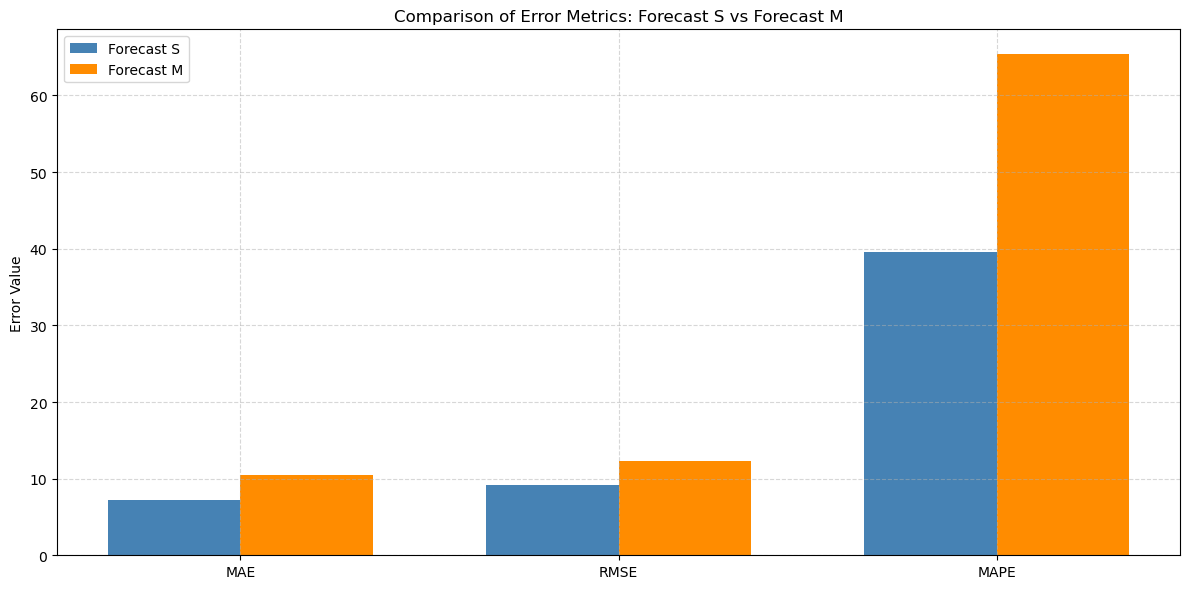

In [30]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [31]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,7.16,10.53
RMSE,9.19,12.29
MAPE,39.57,65.36


    Despite Pressure having a coefficient of -3.2301 and a p-value of 0.000, the SARIMAX model performed worse than SARIMA.

    A statistically significant coefficient doesn't guarantee that the model will forecast better.

### Why did SARIMAX perform worse, despite `Pressure` having a significant coefficient?

Despite `Pressure` having a coefficient of $-3.2301$ and a p-value of $0.000$, the SARIMAX model performed worse than SARIMA.  
This can be explained by the following reasons:

---

#### 1. Statistical Significance $\neq$ Predictive Power

A low p-value means that `Pressure` is statistically associated with `Temp` **in-sample**,  but this does **not guarantee** better **out-of-sample forecasting**.  
It may **explain the past**, but **not predict the future** effectively.

---

#### 2. Timing Mismatch

If `Pressure` changes **at the same time** as `Temp`, it might not provide useful **leading information**.  
Forecasting benefits from exogenous variables that **lead** the target variable, not just correlate with it.

---

#### 3. Noise Amplification

Even significant variables may carry **short-term volatility**.  
SARIMAX may try to fit this noise, leading to **overfitting** and worse forecast performance.

---

#### 4. Redundancy with Seasonal Terms

The SARIMA components (AR, MA, seasonal MA) may already explain the series well.  
Including `Pressure` can lead to **redundancy** or **distort learned patterns**, hurting accuracy.

---

#### 5. Exogenous Input Quality

SARIMAX assumes exogenous variables are **accurate at forecast time**.  
If `Pressure` is noisy, misaligned, or uncertain, it can **inject error** into the forecast.

---

### Conclusion

Even a highly significant exogenous variable can degrade performance if it:

- Adds noise,  
- Does not lead the target variable,  
- Duplicates what is already modeled internally.

---

We may want to test a **lagged version** of `Pressure`, such as `Pressure.shift(1)`,  
to capture possible **predictive effects** more effectively.

# Analysis with Exogenous Variables with Lag

In [32]:
df.head()

,Temp,relative_humidity,wind_speed,Pressure
DATE,,,,
2020-01-01,-0.44,86.0,18.5,100.15
2020-01-02,-0.09,79.0,14.0,100.47
2020-01-03,2.95,82.0,12.0,100.64
2020-01-04,-0.80,86.0,15.0,100.75
2020-01-05,-7.95,74.5,15.0,101.06


In [33]:
# Create lagged version of Pressure
df['Pressure_lag1'] = df['Pressure'].shift(1)

# View the result
df.head()

,Temp,relative_humidity,wind_speed,Pressure,Pressure_lag1
DATE,,,,,
2020-01-01,-0.44,86.0,18.5,100.15,NaN
2020-01-02,-0.09,79.0,14.0,100.47,100.15
2020-01-03,2.95,82.0,12.0,100.64,100.47
2020-01-04,-0.80,86.0,15.0,100.75,100.64
2020-01-05,-7.95,74.5,15.0,101.06,100.75


In [34]:
# Drop rows with NaN (from shift)
df.dropna(inplace=True)

# View the result
df.head()

,Temp,relative_humidity,wind_speed,Pressure,Pressure_lag1
DATE,,,,,
2020-01-02,-0.09,79.0,14.0,100.47,100.15
2020-01-03,2.95,82.0,12.0,100.64,100.47
2020-01-04,-0.80,86.0,15.0,100.75,100.64
2020-01-05,-7.95,74.5,15.0,101.06,100.75
2020-01-06,-7.90,80.0,13.5,100.99,101.06


In [35]:
# Split the data
cutoff = pd.to_datetime("2021-05-01")

train3 = df[df.index < cutoff]
test3 = df[df.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test3.head())

Train shape: (486, 4)
Test shape: (38, 12)

             Temp  relative_humidity  wind_speed  Pressure
DATE                                                      
2021-04-26   4.80               38.0        20.5    101.73
2021-04-27   7.70               48.0         7.0    101.58
2021-04-28  11.25               61.0         8.0    101.11
2021-04-29  11.90               71.5         7.5    100.38
2021-04-30   5.55               84.5        29.5     99.98

             Temp  relative_humidity  wind_speed  Pressure  Pressure_lag1
DATE                                                                     
2021-05-01   5.30               62.5        21.0    101.03          99.98
2021-05-02   7.65               69.5        13.5    100.58         101.03
2021-05-03   7.15               57.5        16.5    101.19         100.58
2021-05-04  10.50               68.0        18.0    100.62         101.19
2021-05-05   8.85               83.0        20.0    100.76         100.62


In [36]:
exog_data = train3[['Pressure_lag1']]  # Multiple column selection
endog_data = train3['Temp']            # Target variable selection

In [37]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                    exog=exog_data, 
                    order=(1, 1, 3), 
                    seasonal_order=(0, 0, 2, 12),
                    enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                    Temp   No. Observations:                  485
Model:             SARIMAX(1, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -1217.940
Date:                                 Wed, 30 Apr 2025   AIC                           2451.880
Time:                                         14:38:10   BIC                           2484.860
Sample:                                     01-02-2020   HQIC                          2464.872
                                          - 04-30-2021                                         
Covariance Type:                                   opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Pressure_lag1     1.6144      0.337      4.788      0.000       0.95

In [38]:
# Must match the structure of training exog
exog_test_M = test3[['Pressure_lag1']] 

# Forecast the next 42 time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=38, exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test3['Forecast M'] = forecast_mean_M.values
test3['Error M'] = test3['Forecast M'] - test3['Temp']
test3['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test3['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test3.head()

,Temp,relative_humidity,wind_speed,Pressure,Pressure_lag1,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
DATE,,,,,,,,,
2021-05-01,5.30,62.5,21.0,101.03,99.98,4.151015,-1.148985,-2.696952,10.998981
2021-05-02,7.65,69.5,13.5,100.58,101.03,7.654838,0.004838,-2.023807,17.333483
2021-05-03,7.15,57.5,16.5,101.19,100.58,7.846458,0.696458,-2.651926,18.344842
2021-05-04,10.50,68.0,18.0,100.62,101.19,8.995966,-1.504034,-1.883884,19.875817
2021-05-05,8.85,83.0,20.0,100.76,100.62,7.848590,-1.001410,-3.300278,18.997457


In [39]:
# Metrics for ForecastM
mae_m = mean_absolute_error(test3['Temp'], test3['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test3['Temp'], test3['Forecast M']))
mape_m = mean_absolute_percentage_error(test3['Temp'], test3['Forecast M']) * 100

# Combine into dictionaries
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    'MAPE': mape_m,
}

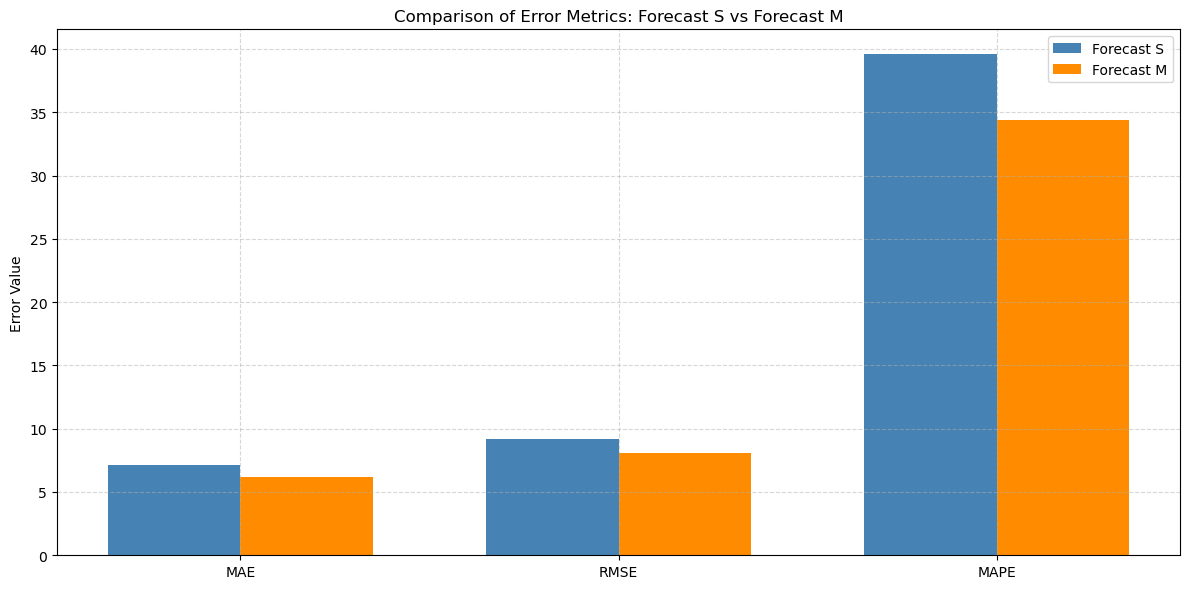

In [40]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,7.16,6.16
RMSE,9.19,8.11
MAPE,39.57,34.36


    It seems that yesterday's pressure provides more useful leading information than today's pressure.